In [1]:

%matplotlib inline
from itertools import chain, combinations
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
import importlib

from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any
import os

from sklearn import metrics
from matplotlib import pyplot as plt
import importlib

In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.models.logistic_relunet import ShallowGaussianRelunet
from bayesianquilts.metrics.classification import classification_metrics, auroc, auprc
from bayesianquilts.sampler import psis, nppsis


2024-12-09 19:21:36.503244: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 19:21:36.527686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 19:21:36.527711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 19:21:36.528665: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 19:21:36.533202: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 19:21:36.533639: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-12-09 19:21:37.091572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
with importlib.resources.path('bayesianquilts', 'data') as data_path:
    roach_path = data_path / "roachdata.csv"
    df = pd.read_csv(roach_path)

In [4]:


y_ = (df['y']>10).astype(int)
X_ = df.iloc[:, 2:]
X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(262, 4)


In [5]:
logistic_relu_horseshoe_code = """
data {
  int<lower=0> N;               // number of observations
  int<lower=0> D_in;            // number of input features
  int<lower=0> D_hidden;        // number of hidden units
  matrix[N, D_in] X;            // input data (N x D_in matrix)
  array[N] int<lower=0, upper=1> y;   // binary target labels (0 or 1)
}

parameters {
  matrix[D_in, D_hidden] w_0;    // weights for the first layer
  vector[D_hidden] b_0;          // biases for the first layer
  
  vector[D_hidden] w_1;          // weights for the output layer
  real b_1;                      // bias for the output layer
}

transformed parameters {
  vector[N] z_output;           // pre-activation output (logits)
  vector[D_hidden] z_hidden;    // hidden layer (latent outputs)
  for (n in 1:N) {
    // Compute hidden layer activations with ReLU
    for (j in 1:D_hidden) {
      z_hidden[j] = X[n] * w_0[, j] + b_0[j];
      z_hidden[j] = fmax(0, z_hidden[j]);  // ReLU activation
    }
    
    // Compute the output logits (before applying sigmoid)
    z_output[n] = dot_product(w_1, z_hidden) + b_1;
  }
}

model {
  // Priors on weights and biases (adjust based on your problem)
  to_vector(w_0) ~ normal(0, 1);
  b_0 ~ normal(0, 1);
  w_1 ~ normal(0, 1);
  b_1 ~ normal(0, 1);

  // Likelihood (logistic sigmoid output)
  y ~ bernoulli_logit(z_output);
}


"""

with open(importlib.resources.path('bayesianquilts', 'stanmodels') / "ovarian_relu_model.stan", 'w') as f:
  f.writelines(logistic_relu_horseshoe_code)


In [6]:
with importlib.resources.path('bayesianquilts', 'stanmodels') as data_path:
    model_path = data_path /  "ovarian_relu_model.stan"
    sm = CmdStanModel(stan_file=model_path)

19:21:38 - cmdstanpy - INFO - compiling stan file /home/josh/workspace/bayesianquilts/bayesianquilts/stanmodels/ovarian_relu_model.stan to exe file /home/josh/workspace/bayesianquilts/bayesianquilts/stanmodels/ovarian_relu_model


19:21:51 - cmdstanpy - INFO - compiled model executable: /home/josh/workspace/bayesianquilts/bayesianquilts/stanmodels/ovarian_relu_model


In [7]:
d_hiden = 3

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

roach_data = {
    "N": N,
    "D_in": d,
    "D_hidden": d_hiden,
    "y": y_.astype(int).tolist(),
    "X": X_scaled.tolist()
}

import json

with open(importlib.resources.path('bayesianquilts', 'data')/ "roach_relu_logit_data.json", "w") as f:
    json.dump(roach_data, f)

In [8]:
print(d)

4


In [9]:
S = 2000
if not os.path.isfile(importlib.resources.path('bayesianquilts', 'data')/'roach_relunet_params.npy'):
    fit = sm.sample(
        data=importlib.resources.path('bayesianquilts', 'data')/"roach_relu_logit_data.json",
        iter_warmup=30000,
        iter_sampling=S,
        thin=2,
        # **control
    )
    print(fit)
    print(fit.diagnose())

In [10]:
if not os.path.isfile(importlib.resources.path('bayesianquilts', 'data')/'roach_relunet_params.npy'):
    params = fit.stan_variables()
    {k: p.shape for k, p in params.items()}
    params['b_1'] = params['b_1'][..., tf.newaxis]
    params['w_1'] = params['w_1'][..., tf.newaxis]
    np.save(importlib.resources.path('bayesianquilts', 'data')/'roach_relunet_params.npy', params)
else:
    params = np.load(importlib.resources.path('bayesianquilts', 'data')/'roach_relunet_params.npy', allow_pickle=True).tolist()

In [11]:
nn_model = ShallowGaussianRelunet(
    dim_regressors=d,
    hidden_size=d_hiden
)

In [12]:
params = {k: tf.cast(v, nn_model.dtype) for k, v in params.items()}

In [13]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00, 23.79it/s]


(0.0, 1.0)

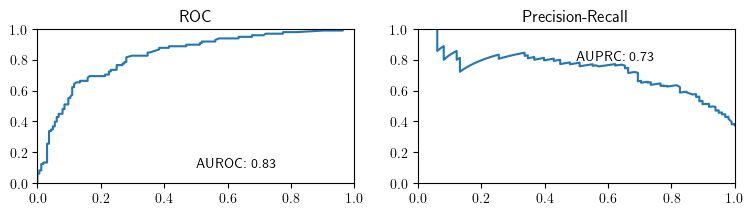

In [14]:
def prediction_fn(data):
    pred = nn_model.predictive_distribution(data, **params)["logits"][..., 1]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [15]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def heaviside(x):
    out = tf.where(x > 0, tf.ones_like(x), tf.zeros_like(x))
    return out


def adaptive_is_loo(
    self: ShallowGaussianRelunet,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
    approx_jacobians=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma

    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)
    mu = self.eval(_X, params)[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = {
                "b_0": -(
                    params["b_0"] - self.surrogate_distribution.model["b_0"].mean()
                )
                / self.surrogate_distribution.model["b_0"].variance(),
                "b_1": -(
                    params["b_1"] - self.surrogate_distribution.model["b_1"].mean()
                )
                / self.surrogate_distribution.model["b_1"].variance(),
                "w_0": -(
                    params["w_0"] - self.surrogate_distribution.model["w_0"].mean()
                )
                / self.surrogate_distribution.model["w_0"].variance(),
                "w_1": -(
                    params["w_1"] - self.surrogate_distribution.model["w_1"].mean()
                )
                / self.surrogate_distribution.model["w_1"].variance(),
            }
            b0_sd = self.surrogate_distribution.model["b_0"].variance() ** 0.5
            b1_sd = self.surrogate_distribution.model["b_1"].variance() ** 0.5
            w0_sd = self.surrogate_distribution.model["w_0"].variance() ** 0.5
            w1_sd = self.surrogate_distribution.model["w_1"].variance() ** 0.5
            log_pi = (
                self.surrogate_distribution.model["b_0"].log_prob(params["b_0"])
                + self.surrogate_distribution.model["b_1"].log_prob(params["b_1"])
                + self.surrogate_distribution.model["w_1"].log_prob(params["w_1"])
                + self.surrogate_distribution.model["w_0"].log_prob(params["w_0"])
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob(params)

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
            z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
            # pi \propto #@TODO

            grad_log_pi = {
                "b_0": (
                    tf.reduce_sum(
                        (
                            params["w_1"][..., tf.newaxis, :, :]
                            * log_ell_prime[..., tf.newaxis, tf.newaxis]
                        )
                        * heaviside(z1)[..., tf.newaxis],
                        axis=1,
                        keepdims=False,
                    )[..., 0]
                    - 0.5 * params["b_0"] ** 2
                ),
                "b_1": tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis], axis=1, keepdims=False
                )
                - 0.5 * params["b_1"] ** 2,
                "w_0": (
                    tf.reduce_sum(
                        (
                            (
                                params["w_1"][..., tf.newaxis, :, :]
                                * log_ell_prime[..., tf.newaxis, tf.newaxis]
                                * heaviside(z1)[..., tf.newaxis]
                            )[..., tf.newaxis, :, 0]
                            * X[..., tf.newaxis]
                        ),
                        axis=1,
                        keepdims=False,
                    )  # want S x N x k
                    - 0.5 * params["w_0"] ** 2
                ),
                "w_1": tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis, tf.newaxis] * z1[..., tf.newaxis],
                    axis=1,
                    keepdims=False,
                )
                - 0.5 * params["w_1"] ** 2,
            }

            grad_log_prior = {
                "b_0": -0.5 * params["b_0"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "b_1": -0.5 * params["b_1"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "w_0": -0.5 * params["w_0"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "w_1": -0.5 * params["w_1"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
            }
            # grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            b0_sd = tf.math.reduce_std(params["b_0"], 0, keepdims=True)
            b1_sd = tf.math.reduce_std(params["b_1"], 0, keepdims=True)
            w0_sd = tf.math.reduce_std(params["w_0"], 0, keepdims=True)
            w1_sd = tf.math.reduce_std(params["w_1"], 0, keepdims=True)

        b0_adj, b1_adj, w0_adj, w1_adj, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            b0_sd=b0_sd,
            b1_sd=b1_sd,
            w0_sd=w0_sd,
            w1_sd=w1_sd,
        )
        transformed = {"b_0": b0_adj, "b_1": b1_adj, "w_0": w0_adj, "w_1": w1_adj}
        mu_new = self.nn.eval(X[:, tf.newaxis, :], [w0_adj, b0_adj, w1_adj, b1_adj])[
            ..., 0, 0
        ]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                self.nn.eval(X, [w0_adj, b0_adj, w1_adj, b1_adj])[..., 0]
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob(transformed)

            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    tf.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * tf.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = entropy(eta_weights)
        psis_entropy = entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        out = (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )
        return out

    def T_kl(X, y, log_pi, grad_log_pi, b0_sd, b1_sd, w0_sd, w1_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        pre = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ]
        z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
        Q_b1 = pre
        Q_w1 = (pre * z1)[..., tf.newaxis]
        Q_b0 = (
            pre[..., tf.newaxis]
            * heaviside(z1)[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, :, :]
        )
        Q_w0 = (
            pre[..., tf.newaxis, :]
            * heaviside(z1)[..., tf.newaxis, :]
            * X[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, tf.newaxis, :, 0]
        )

        standardized = tf.concat(
            [
                tf.reduce_max(tf.math.abs(Q_b0 / tf.transpose(b0_sd)), axis=-1),
                tf.math.abs(Q_b1 / b1_sd),
                tf.reduce_max(tf.math.abs(Q_w0 / w0_sd), axis=-1),
                (Q_w1 / w1_sd)[..., 0],
            ],
            axis=-1,
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        b0_adj = params["b_0"][..., tf.newaxis, :] + h * Q_b0[..., 0]
        b1_adj = params["b_1"][..., tf.newaxis, :] + h * Q_b1
        w0_adj = params["w_0"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w0
        w1_adj = params["w_1"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w1

        eigen_plus = tf.reduce_sum(
            heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis] ** 2, axis=-1
        )
        eigen_plus = tf.math.sqrt(eigen_plus)

        u_k = heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis]
        u_k = tf.math.sqrt(tf.math.reduce_sum(u_k**2, axis=-1))  # norm |u_k|

        #
        Jpre = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )

        # assumeble the Jacobian approximation
        # |J| = | 1 + h\nabla\cdot Q|

        dQ_b0 = (grad_log_pi["b_0"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :, tf.newaxis
        ] + (1 - 2 * y[ tf.newaxis, :, tf.newaxis, tf.newaxis]) * (
            heaviside(z1)[..., tf.newaxis] * params["w_1"][..., tf.newaxis, :, :]
        )

        dQ_w0 = (
            grad_log_pi["w_0"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + (1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * heaviside(z1)[..., tf.newaxis, :]
            * X[tf.newaxis, :, :, tf.newaxis]
            * params["w_1"][..., 0][..., tf.newaxis, tf.newaxis, :]
        )

        dQ_b1 = (grad_log_pi["b_1"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :
        ] + (1 - 2 * y[tf.newaxis, :, tf.newaxis]) 

        dQ_w1 = (
            grad_log_pi["w_1"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + (1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * z1[..., tf.newaxis]
        )
        
        dQ_b0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_b0*Q_b0, axis=[-1, -2])
        dQ_b1 = tf.reduce_sum(h*dQ_b1*Q_b1, axis=[-1])
        dQ_w0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w0*Q_w0, axis=[-1, -2])
        dQ_w1 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w1*Q_w1, axis=[-1, -2])

        logJ = tf.math.log1p(dQ_b0 + dQ_b1 + dQ_w0 + dQ_w1)
        return b0_adj, b1_adj, w0_adj, w1_adj, logJ

    def T_I(X, y, **kwargs):
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        out = (
            params["b_0"][..., tf.newaxis, :] + Q[..., tf.newaxis],
            params["b_1"][..., tf.newaxis, :] + Q[..., tf.newaxis],
            params["w_0"][..., tf.newaxis, :, :] + Q[..., tf.newaxis, tf.newaxis],
            params["w_1"][..., tf.newaxis, :, :] + Q[..., tf.newaxis, tf.newaxis],
            tf.zeros_like(Q),
        )
        return out

    def T_var(X, y, log_pi, grad_log_pi, b0_sd, b1_sd, w0_sd, w1_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        pre = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2* mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ]
        z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
        Q_b1 = pre
        Q_w1 = (pre * z1)[..., tf.newaxis]
        Q_b0 = (
            pre[..., tf.newaxis]
            * heaviside(z1)[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, :, :]
        )
        Q_w0 = (
            pre[..., tf.newaxis, :]
            * heaviside(z1)[..., tf.newaxis, :]
            * X[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, tf.newaxis, :, 0]
        )

        standardized = tf.concat(
            [
                tf.reduce_max(tf.math.abs(Q_b0 / tf.transpose(b0_sd)), axis=-1),
                tf.math.abs(Q_b1 / b1_sd),
                tf.reduce_max(tf.math.abs(Q_w0 / w0_sd), axis=-1),
                (Q_w1 / w1_sd)[..., 0],
            ],
            axis=-1,
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        b0_adj = params["b_0"][..., tf.newaxis, :] + h * Q_b0[..., 0]
        b1_adj = params["b_1"][..., tf.newaxis, :] + h * Q_b1
        w0_adj = params["w_0"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w0
        w1_adj = params["w_1"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w1

        eigen_plus = tf.reduce_sum(
            heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis] ** 2, axis=-1
        )
        eigen_plus = tf.math.sqrt(eigen_plus)

        u_k = heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis]
        u_k = tf.math.sqrt(tf.math.reduce_sum(u_k**2, axis=-1))  # norm |u_k|

        #
        Jpre = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )

        # assumeble the Jacobian approximation
        # |J| = | 1 + h\nabla\cdot Q|

        dQ_b0 = (grad_log_pi["b_0"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :, tf.newaxis
        ] + 2*(1 - 2 * y[ tf.newaxis, :, tf.newaxis, tf.newaxis]) * (
            heaviside(z1)[..., tf.newaxis] * params["w_1"][..., tf.newaxis, :, :]
        )

        dQ_w0 = (
            grad_log_pi["w_0"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * heaviside(z1)[..., tf.newaxis, :]
            * X[tf.newaxis, :, :, tf.newaxis]
            * params["w_1"][..., 0][..., tf.newaxis, tf.newaxis, :]
        )

        dQ_b1 = (grad_log_pi["b_1"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :
        ] + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis])

        dQ_w1 = (
            grad_log_pi["w_1"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * z1[..., tf.newaxis]
        )
        
        dQ_b0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_b0*Q_b0, axis=[-1, -2])
        dQ_b1 = tf.reduce_sum(h*dQ_b1*Q_b1, axis=[-1])
        dQ_w0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w0*Q_w0, axis=[-1, -2])
        dQ_w1 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w1*Q_w1, axis=[-1, -2])

        logJ = tf.math.log1p(dQ_b0 + dQ_b1 + dQ_w0 + dQ_w1)
        return b0_adj, b1_adj, w0_adj, w1_adj, logJ

    def T_MM1(X, y, **kwargs):
        # need to transform b_0, b_1, w_0, w_1
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_bar(param, weights):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            if len(param.shape) > 2:
                weights = weights[..., tf.newaxis]
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        bar_b0, bar_b0_w, b0_v, b0_v_w = theta_bar(params["b_0"], weights)
        bar_b1, bar_b1_w, b1_v, b1_v_w = theta_bar(params["b_1"], weights)

        bar_w0, bar_w0_w, w0_v, w0_v_w = theta_bar(params["w_0"], weights)
        bar_w1, bar_w1_w, w1_v, w1_v_w = theta_bar(params["w_1"], weights)

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        b0_adj = params["b_0"][:, tf.newaxis, ...] + hbar * (-bar_b0 + bar_b0_w)
        b1_adj = params["b_1"][:, tf.newaxis, ...] + hbar * (-bar_b1 + bar_b1_w)
        w0_adj = params["w_0"][:, tf.newaxis, ...] + hbar * (-bar_w0 + bar_w0_w)
        w1_adj = params["w_1"][:, tf.newaxis, ...] + hbar * (-bar_w1 + bar_w1_w)

        return b0_adj, b1_adj, w0_adj, w1_adj, tf.zeros_like(ell)

    def T_MM2(X, y, **kwargs):

        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_bar(param, weights):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            if len(param.shape) > 2:
                weights = weights[..., tf.newaxis]
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        bar_b0, bar_b0_w, b0_v, b0_v_w = theta_bar(params["b_0"], weights)
        bar_b1, bar_b1_w, b1_v, b1_v_w = theta_bar(params["b_1"], weights)

        bar_w0, bar_w0_w, w0_v, w0_v_w = theta_bar(params["w_0"], weights)
        bar_w1, bar_w1_w, w1_v, w1_v_w = theta_bar(params["w_1"], weights)

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        b0_adj = params["b_0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(b0_v_w / b0_v) - 1) * params["b_0"][:, tf.newaxis, ...]
            - tf.math.sqrt(b0_v_w / b0_v) * bar_b0
            + bar_b0_w
        )
        b1_adj = params["b_1"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(b1_v_w / b1_v) - 1) * params["b_1"][:, tf.newaxis, ...]
            - tf.math.sqrt(b1_v_w / b1_v) * bar_b1
            + bar_b0_w
        )
        w0_adj = params["w_0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(w0_v_w / w0_v) - 1) * params["w_0"][:, tf.newaxis, ...]
            - tf.math.sqrt(w0_v_w / w0_v) * bar_w0
            + bar_w0_w
        )
        w1_adj = params["w_1"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(w1_v_w / w1_v) - 1) * params["w_1"][:, tf.newaxis, ...]
            - tf.math.sqrt(w1_v_w / w1_v) * bar_w1
            + bar_w1_w
        )

        # piece together the Jacobian
        # every component gets multiplied by something like (sqrt(beta0_v_w/beta0_v)-1)

        J_b0 = tf.math.sqrt(b0_v_w / b0_v) - 1
        J_b1 = tf.math.sqrt(b1_v_w / b1_v) - 1
        J_w0 = tf.math.sqrt(w0_v_w / w0_v) - 1
        J_w1 = tf.math.sqrt(w1_v_w / w1_v) - 1

        J_b0 = tf.reduce_sum(tf.math.log1p(hbar * J_b0), axis=-1)
        J_b1 = tf.reduce_sum(tf.math.log1p(hbar * J_b1), axis=-1)
        J_w0 = tf.reduce_sum(tf.math.log1p(hbar * J_w0), axis=[-1, -2])
        J_w1 = tf.reduce_sum(tf.math.log1p(hbar * J_w1), axis=[-1, -2])
        # shift by mean
        return (
            b0_adj,
            b1_adj,
            w0_adj,
            w1_adj,
            tf.zeros_like(ell) + J_b0 + J_b1 + J_w0 + J_w1,
        )

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        # "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    nn_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "KL", "Var", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

I: 0.0008257510987200439 entropy: 5.748531146076027 khat>0.7: 13
KL: 0.0008257758267346353 entropy: 5.748530118120903 khat>0.7: 13
Var: 0.0008257824545108327 entropy: 5.748528947459313 khat>0.7: 13
MM1: 0.000825750342112251 entropy: 5.748643793669039 khat>0.7: 13
MM2: 0.004896915570872997 entropy: 5.9703238638948815 khat>0.7: 7


In [16]:
base = 4
h_vals = [base**-r for r in range(-3, 7)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(params['w_0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = {k: v.numpy()[sample_ndx] for k, v in params.items()}
        params_ = {k: tf.cast(v, nn_model.dtype) for k, v in params_.items()}

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(nn_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

  0%|          | 0/1 [00:00<?, ?it/s]2024-12-09 19:21:54.018221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1548384000 exceeds 10% of free system memory.
2024-12-09 19:21:54.105951: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1548384000 exceeds 10% of free system memory.
2024-12-09 19:21:54.296283: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1548384000 exceeds 10% of free system memory.
2024-12-09 19:21:55.393760: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1548384000 exceeds 10% of free system memory.
2024-12-09 19:21:55.484312: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1548384000 exceeds 10% of free system memory.
100%|██████████| 1/1 [00:14<00:00, 14.02s/it]

{1000: {64: {'I0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 22

## Look at S=2000 case

In [17]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df.head()
I0_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I0")]

kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
mm1_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="MM1")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I_ = I_.explode(['khat', 'ndx'])
mm1_ = mm1_.explode(['khat', 'ndx'])

original = I_[['khat', 'ndx']].drop_duplicates()


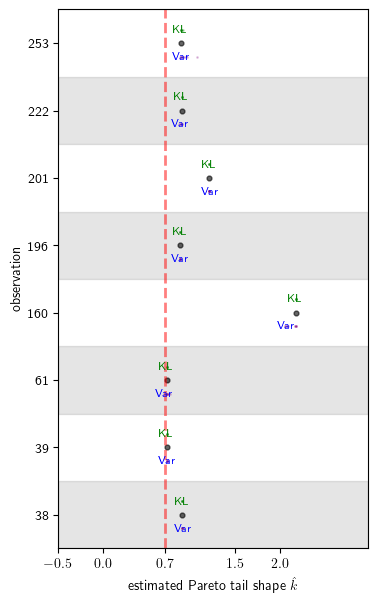

In [18]:
fig = plt.figure(figsize=(4, 7))
ndx_high_khat = loo['KL']['ndx'].tolist()
ymax = (len(ndx_high_khat))
_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]) + 0.2, s=1, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]) - 0.2, s=1, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<3]
ll_ = ll_[ll_.khat<3]
var_ = var_[var_.khat<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)+0.2, color='green', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x) + 0.2, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)-0.2, color='purple', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x)-0.2, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
#for x, v in var_vals.items():
#    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 3))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
# _ = plt.savefig("khat_relu.pdf", bbox_inches='tight')

In [19]:
len(ndx_high_khat)

8

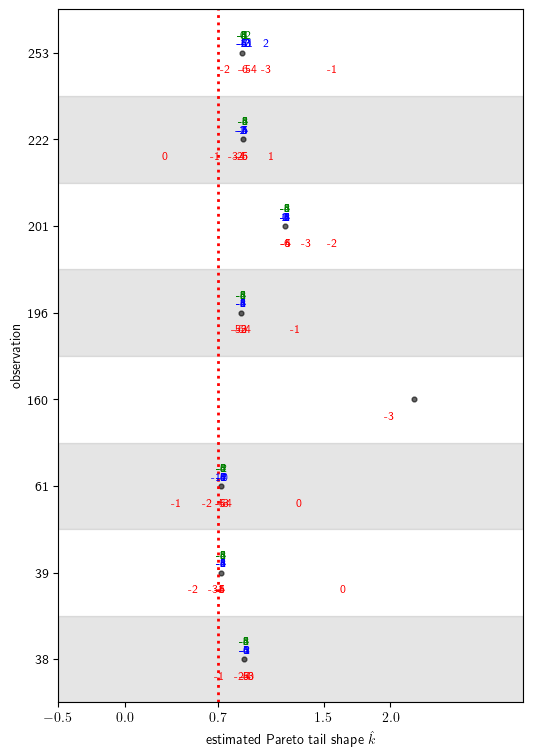

In [20]:
fig = plt.figure(figsize=(6, 9))

_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]), s=0, color='purple', alpha=0.2)
_ = plt.scatter(ll_.khat, np.array([ndx_high_khat.index(i) for i in ll_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(mm1_.khat, np.array([ndx_high_khat.index(i) for i in mm1_['ndx']]), s=0, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<2]
ll_ = ll_[ll_.khat<2]
var_ = var_[var_.khat<2]
mm1_ = mm1_[mm1_.khat<2]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.2, str(s),  ha='center', va='center', color='green', fontsize=8)
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.1, str(s),  ha='center', va='center', color='blue', fontsize=8)

for x, y, s in zip( ll_.khat, ll_['ndx'], ll_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.1, str(s),  ha='center', va='center', color='orange', fontsize=8)

for x, y, s in zip( mm1_.khat, mm1_['ndx'], mm1_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.2, str(s),  ha='center', va='center', color='red', fontsize=8)
    
_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 3))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_detailed_relu.pdf", bbox_inches='tight')

In [22]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_ = df_[df_['T']!="MM2"]

df_ = df_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_ = df_.reset_index()
df_['y'] = [y_.tolist()[i] for i in df_['ndx'].values]


In [23]:
fpr, tpr, thresholds = metrics.roc_curve(df_['y'], df_.p_psis, pos_label=1)
precision, recall, thresholds_pr = metrics.precision_recall_curve(df_['y'], df_.p_psis)

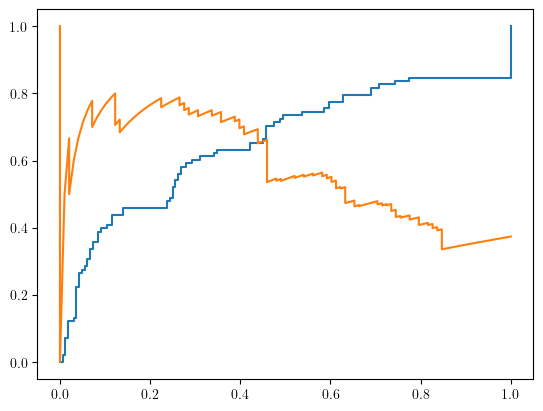

In [24]:
plt.plot(fpr, tpr)
plt.plot(recall, precision)

# Cross-tabulations

In [25]:
df__ = df.explode(['khat', 'ndx'])[['ndx', 'khat', 'T']]
transforms = ["KL", "Var", "LL", "MM1", "MM2"]


In [26]:
for T in transforms:
    _df__ = df__.loc[(df__['T']==T) & (df__['khat']<0.7)]
    print(f"{T}: {_df__.groupby('ndx').min().shape[0]}")
print(len(df__[df__['T']!="I0"].ndx.unique()))

KL: 0
Var: 1
LL: 0
MM1: 3
MM2: 5
8


In [27]:
print(f"{df__.loc[((df__['T']=='KL') | (df__['T']=='Var')) & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

1


In [28]:
print(f"{df__.loc[((df__['T']=='LL') | (df__['T']=='MM1')) &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

3


In [29]:
print(f"{df__.loc[(df__['T']!='MM1') &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

5


In [30]:
len(df__[df__['T']!="I0"].ndx.unique())

8

# Compare with variational model

In [31]:
lr_model2 = ShallowGaussianRelunet(
    dim_regressors=d,
    hidden_size=3
)

In [32]:

losses = lr_model2.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=N,
    batches_per_step=9,
    check_every=int(N/batch_size)*50,
    batch_size=batch_size,
    num_steps=12000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 12000 steps of 9 accumulated batches, checking every 50 steps
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-1


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 48/12000 [00:02<06:01, 33.09it/s] 

Step 50: average-batch loss:253.03620934205017 rel loss: 3.952003559491426e+305
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-2


  1%|          | 96/12000 [00:03<05:56, 33.36it/s]

Step 100: average-batch loss:251.54507476263012 rel loss: 0.0059279021098988085
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-3


  1%|          | 148/12000 [00:05<05:50, 33.78it/s]

Step 150: average-batch loss:250.0451788146241 rel loss: 0.005998499771587241
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-4


  2%|▏         | 196/12000 [00:06<05:54, 33.26it/s]

Step 200: average-batch loss:248.07202696208435 rel loss: 0.007953947394646542
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-5


  2%|▏         | 248/12000 [00:08<05:50, 33.50it/s]

Step 250: average-batch loss:246.09614030939943 rel loss: 0.008028921746601863
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-6


  2%|▏         | 296/12000 [00:09<05:40, 34.39it/s]

Step 300: average-batch loss:243.98187374566544 rel loss: 0.008665670655263396
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-7


  3%|▎         | 348/12000 [00:11<05:46, 33.67it/s]

Step 350: average-batch loss:241.7510358294661 rel loss: 0.00922783188309891
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-8


  3%|▎         | 396/12000 [00:12<05:40, 34.07it/s]

Step 400: average-batch loss:240.0257960981652 rel loss: 0.007187726316696946
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-9


  4%|▎         | 448/12000 [00:14<05:40, 33.94it/s]

Step 450: average-batch loss:237.72539853910212 rel loss: 0.009676700820357199
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-10


  4%|▍         | 496/12000 [00:15<05:38, 33.95it/s]

Step 500: average-batch loss:236.01513626429954 rel loss: 0.007246409284900063
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-11


  5%|▍         | 548/12000 [00:17<05:41, 33.54it/s]

Step 550: average-batch loss:234.16637012429996 rel loss: 0.007895096716997504
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-12


  5%|▍         | 596/12000 [00:18<05:44, 33.12it/s]

Step 600: average-batch loss:232.01634201894052 rel loss: 0.009266709778503114
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-13


  5%|▌         | 648/12000 [00:20<05:41, 33.28it/s]

Step 650: average-batch loss:230.42449314553122 rel loss: 0.006908331886419412
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-14


  6%|▌         | 696/12000 [00:21<05:36, 33.60it/s]

Step 700: average-batch loss:228.612913678188 rel loss: 0.007924221944405695
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-15


  6%|▌         | 748/12000 [00:23<05:35, 33.50it/s]

Step 750: average-batch loss:226.62525396235478 rel loss: 0.00877068941382584
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-16


  7%|▋         | 796/12000 [00:24<05:37, 33.22it/s]

Step 800: average-batch loss:224.76807457235336 rel loss: 0.00826264759145583
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-17


  7%|▋         | 848/12000 [00:26<05:33, 33.43it/s]

Step 850: average-batch loss:223.10686163352952 rel loss: 0.007445817339103221
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-18


  7%|▋         | 896/12000 [00:27<05:30, 33.55it/s]

Step 900: average-batch loss:221.22787281888583 rel loss: 0.008493454241102684
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-19


  8%|▊         | 948/12000 [00:29<05:29, 33.57it/s]

Step 950: average-batch loss:219.41987103421707 rel loss: 0.008239918181279102
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-20


  8%|▊         | 996/12000 [00:30<05:27, 33.58it/s]

Step 1000: average-batch loss:217.89123990357882 rel loss: 0.007015569470873154
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-21


  9%|▊         | 1048/12000 [00:32<05:29, 33.24it/s]

Step 1050: average-batch loss:216.23757520454535 rel loss: 0.007647443777841206
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-22


  9%|▉         | 1096/12000 [00:33<05:34, 32.63it/s]

Step 1100: average-batch loss:214.72259057238136 rel loss: 0.007055543751244456
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-23


 10%|▉         | 1148/12000 [00:35<05:22, 33.69it/s]

Step 1150: average-batch loss:212.77144098702013 rel loss: 0.009170166711801625
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-24


 10%|▉         | 1196/12000 [00:36<05:22, 33.51it/s]

Step 1200: average-batch loss:211.79035623425847 rel loss: 0.004632339121600492
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-25


 10%|█         | 1248/12000 [00:38<05:16, 33.96it/s]

Step 1250: average-batch loss:209.82758419124713 rel loss: 0.009354213606264346
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-26


 11%|█         | 1296/12000 [00:39<05:16, 33.79it/s]

Step 1300: average-batch loss:208.53736668301877 rel loss: 0.006186984753622165
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-27


 11%|█         | 1348/12000 [00:41<05:19, 33.35it/s]

Step 1350: average-batch loss:207.19668991903643 rel loss: 0.006470551071574663
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-28


 12%|█▏        | 1396/12000 [00:42<05:15, 33.64it/s]

Step 1400: average-batch loss:205.6199534829275 rel loss: 0.007668207337863404
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-29


 12%|█▏        | 1448/12000 [00:44<05:15, 33.43it/s]

Step 1450: average-batch loss:204.26369975483672 rel loss: 0.006639719782411692
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-30


 12%|█▏        | 1496/12000 [00:45<05:10, 33.88it/s]

Step 1500: average-batch loss:202.95833316034427 rel loss: 0.006431697453196804
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-31


 13%|█▎        | 1548/12000 [00:47<05:11, 33.50it/s]

Step 1550: average-batch loss:201.55853508800087 rel loss: 0.006944871234216137
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-32


 13%|█▎        | 1596/12000 [00:48<05:10, 33.47it/s]

Step 1600: average-batch loss:200.3873573300365 rel loss: 0.005844569106400445
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-33


 14%|█▎        | 1648/12000 [00:50<05:12, 33.16it/s]

Step 1650: average-batch loss:199.20422318900182 rel loss: 0.005939302501193191
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-34


 14%|█▍        | 1696/12000 [00:51<05:08, 33.45it/s]

Step 1700: average-batch loss:197.65872475556137 rel loss: 0.007819024610989113
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-35


 15%|█▍        | 1748/12000 [00:53<05:11, 32.89it/s]

Step 1750: average-batch loss:196.59319872565698 rel loss: 0.0054199536749555445
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-36


 15%|█▍        | 1796/12000 [00:54<05:04, 33.46it/s]

Step 1800: average-batch loss:195.45379558774943 rel loss: 0.005829526791645304
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-37


 15%|█▌        | 1848/12000 [00:56<05:04, 33.39it/s]

Step 1850: average-batch loss:194.25993289892367 rel loss: 0.006145697010237024
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-38


 16%|█▌        | 1896/12000 [00:58<05:06, 32.99it/s]

Step 1900: average-batch loss:193.439033274792 rel loss: 0.004243712399893622
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-39


 16%|█▌        | 1948/12000 [00:59<04:59, 33.53it/s]

Step 1950: average-batch loss:192.2956674042053 rel loss: 0.005945874319588034
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-40


 17%|█▋        | 1996/12000 [01:01<04:59, 33.36it/s]

Step 2000: average-batch loss:190.77302993213178 rel loss: 0.007981408444449388
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-41


 17%|█▋        | 2048/12000 [01:02<04:59, 33.23it/s]

Step 2050: average-batch loss:190.00610990274697 rel loss: 0.00403629141072015
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-42


 17%|█▋        | 2096/12000 [01:04<04:52, 33.86it/s]

Step 2100: average-batch loss:188.7805593015642 rel loss: 0.006491932250423235
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-43


 18%|█▊        | 2148/12000 [01:05<04:56, 33.22it/s]

Step 2150: average-batch loss:187.74917167170557 rel loss: 0.005493433716246194
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-44


 18%|█▊        | 2196/12000 [01:07<04:50, 33.80it/s]

Step 2200: average-batch loss:187.16618623030354 rel loss: 0.003114801092782222
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-45


 19%|█▊        | 2248/12000 [01:08<04:47, 33.91it/s]

Step 2250: average-batch loss:186.11105723445544 rel loss: 0.0056693514696382775
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-46


 19%|█▉        | 2296/12000 [01:10<05:04, 31.86it/s]

Step 2300: average-batch loss:184.92513032449276 rel loss: 0.006413011081196552
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-47


 20%|█▉        | 2348/12000 [01:11<04:44, 33.92it/s]

Step 2350: average-batch loss:184.13305810715076 rel loss: 0.004301629623079812
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-48


 20%|█▉        | 2396/12000 [01:13<04:46, 33.50it/s]

Step 2400: average-batch loss:183.24192293005777 rel loss: 0.004863162112925062
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-49


 20%|██        | 2448/12000 [01:14<04:45, 33.41it/s]

Step 2450: average-batch loss:182.81057486652222 rel loss: 0.0023595356223265387
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-50


 21%|██        | 2496/12000 [01:16<04:44, 33.42it/s]

Step 2500: average-batch loss:182.16708214960389 rel loss: 0.0035324313774201294
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-51


 21%|██        | 2548/12000 [01:17<04:41, 33.63it/s]

Step 2550: average-batch loss:180.9650785700381 rel loss: 0.006642185271677107
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-52


 22%|██▏       | 2596/12000 [01:19<04:44, 33.06it/s]

Step 2600: average-batch loss:180.51603242411198 rel loss: 0.00248756933052404
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-53


 22%|██▏       | 2648/12000 [01:20<04:42, 33.15it/s]

Step 2650: average-batch loss:179.39806022560444 rel loss: 0.006231796470383368
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-54


 22%|██▏       | 2696/12000 [01:22<04:45, 32.60it/s]

Step 2700: average-batch loss:179.06558393204426 rel loss: 0.001856729172962417
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-55


 23%|██▎       | 2748/12000 [01:23<04:45, 32.43it/s]

Step 2750: average-batch loss:178.5498202652874 rel loss: 0.002888626076411346
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-56


 23%|██▎       | 2796/12000 [01:25<04:39, 32.87it/s]

Step 2800: average-batch loss:177.7217228312193 rel loss: 0.004659517254705746
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-57


 24%|██▎       | 2848/12000 [01:26<04:42, 32.42it/s]

Step 2850: average-batch loss:177.1813392513859 rel loss: 0.0030498899157020668
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-58


 24%|██▍       | 2896/12000 [01:28<04:32, 33.42it/s]

Step 2900: average-batch loss:176.72573639839914 rel loss: 0.002578022093848798
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-59


 25%|██▍       | 2948/12000 [01:29<04:30, 33.48it/s]

Step 2950: average-batch loss:176.28946080690562 rel loss: 0.0024747684262950696
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-60


 25%|██▍       | 2996/12000 [01:31<04:35, 32.73it/s]

Step 3000: average-batch loss:175.61598843761607 rel loss: 0.0038349148917542477
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-61


 25%|██▌       | 3048/12000 [01:33<04:32, 32.86it/s]

Step 3050: average-batch loss:174.78891336155377 rel loss: 0.0047318508946358724
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-62


 26%|██▌       | 3096/12000 [01:34<04:28, 33.14it/s]

Step 3100: average-batch loss:174.4012894963763 rel loss: 0.002222597472167853
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-63


 26%|██▌       | 3148/12000 [01:36<04:22, 33.71it/s]

Step 3150: average-batch loss:173.86530457323948 rel loss: 0.0030827595215297443
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-64


 27%|██▋       | 3196/12000 [01:37<04:24, 33.26it/s]

Step 3200: average-batch loss:173.26347511803863 rel loss: 0.0034734929262549455
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-65


 27%|██▋       | 3248/12000 [01:39<04:28, 32.58it/s]

Step 3250: average-batch loss:173.04819030064544 rel loss: 0.0012440743645984258
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-66


 27%|██▋       | 3296/12000 [01:40<04:23, 32.98it/s]

Step 3300: average-batch loss:172.02254024540554 rel loss: 0.005962300369339541
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-67


 28%|██▊       | 3348/12000 [01:42<04:22, 32.94it/s]

Step 3350: average-batch loss:171.70202877844682 rel loss: 0.001866672567813905
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-68


 28%|██▊       | 3396/12000 [01:43<04:17, 33.42it/s]

Step 3400: average-batch loss:171.367358517943 rel loss: 0.0019529405331225073
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-69


 29%|██▊       | 3448/12000 [01:45<04:15, 33.51it/s]

Step 3450: average-batch loss:170.95493918013716 rel loss: 0.0024124447049246028
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-70


 29%|██▉       | 3496/12000 [01:46<04:21, 32.57it/s]

Step 3500: average-batch loss:170.46465602398666 rel loss: 0.0028761572491690438
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-71


 30%|██▉       | 3548/12000 [01:48<04:22, 32.17it/s]

Step 3550: average-batch loss:170.1762062298913 rel loss: 0.0016950066080665192
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-72


 30%|██▉       | 3596/12000 [01:49<04:11, 33.38it/s]

Step 3600: average-batch loss:169.45021163986507 rel loss: 0.0042844124123562555
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-73


 30%|███       | 3648/12000 [01:51<04:08, 33.59it/s]

Step 3650: average-batch loss:169.39108612527855 rel loss: 0.00034904737869617295
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-74


 31%|███       | 3696/12000 [01:52<04:12, 32.86it/s]

Step 3700: average-batch loss:168.65558016643843 rel loss: 0.004360993915020688
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-75


 31%|███       | 3748/12000 [01:54<04:09, 33.08it/s]

Step 3750: average-batch loss:168.35392256914827 rel loss: 0.0017918061705171073
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-76


 32%|███▏      | 3796/12000 [01:55<04:16, 32.02it/s]

Step 3800: average-batch loss:168.0184323419963 rel loss: 0.0019967465621218224
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-77


 32%|███▏      | 3848/12000 [01:57<04:06, 33.01it/s]

Step 3850: average-batch loss:167.45209790704047 rel loss: 0.0033820683170551593
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-78


 32%|███▏      | 3896/12000 [01:58<04:01, 33.53it/s]

Step 3900: average-batch loss:167.1634708130776 rel loss: 0.0017266158243723964
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-79


 33%|███▎      | 3948/12000 [02:00<04:01, 33.36it/s]

Step 3950: average-batch loss:166.77342060894466 rel loss: 0.002338803166048472
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-80


 33%|███▎      | 3996/12000 [02:02<04:09, 32.08it/s]

Step 4000: average-batch loss:166.50569994405882 rel loss: 0.001607876877342875
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-81


 34%|███▎      | 4048/12000 [02:03<04:06, 32.29it/s]

Step 4050: average-batch loss:165.8814441507617 rel loss: 0.0037632647611252263
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-82


 34%|███▍      | 4096/12000 [02:05<04:03, 32.40it/s]

Step 4100: average-batch loss:165.50694919775216 rel loss: 0.0022627143743799813
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-83


 35%|███▍      | 4148/12000 [02:06<03:57, 33.08it/s]

Step 4150: average-batch loss:165.29409774427546 rel loss: 0.0012877135746613413
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-84


 35%|███▍      | 4196/12000 [02:08<03:59, 32.64it/s]

Step 4200: average-batch loss:164.7565972569302 rel loss: 0.003262391286869372
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-85


 35%|███▌      | 4248/12000 [02:09<04:01, 32.11it/s]

Step 4250: average-batch loss:164.30035378870176 rel loss: 0.002776886706009177
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-86


 36%|███▌      | 4296/12000 [02:11<03:53, 33.04it/s]

Step 4300: average-batch loss:163.83395799343256 rel loss: 0.0028467590051623423
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-87


 36%|███▌      | 4348/12000 [02:12<03:54, 32.62it/s]

Step 4350: average-batch loss:163.6992177898223 rel loss: 0.0008230961969729499
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-88


 37%|███▋      | 4396/12000 [02:14<03:51, 32.78it/s]

Step 4400: average-batch loss:163.31114697407935 rel loss: 0.0023762665496713346
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-89


 37%|███▋      | 4448/12000 [02:16<03:48, 33.03it/s]

Step 4450: average-batch loss:163.11141257896895 rel loss: 0.0012245274070794862
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-90


 37%|███▋      | 4496/12000 [02:17<03:47, 33.03it/s]

Step 4500: average-batch loss:162.5627370118763 rel loss: 0.003375161966254136
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-91


 38%|███▊      | 4548/12000 [02:19<03:46, 32.91it/s]

Step 4550: average-batch loss:162.5024269431916 rel loss: 0.0003711333413239994
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-92


 38%|███▊      | 4596/12000 [02:20<03:41, 33.39it/s]

Step 4600: average-batch loss:161.8002572139963 rel loss: 0.004339731847685619
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-93


 39%|███▊      | 4648/12000 [02:22<03:42, 33.11it/s]

Step 4650: average-batch loss:161.90649005490667 rel loss: 0.0006561370138673216
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 39%|███▉      | 4696/12000 [02:23<03:49, 31.88it/s]

Step 4700: average-batch loss:161.29855744681794 rel loss: 0.003110379752427619
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-94


 40%|███▉      | 4748/12000 [02:25<03:39, 33.10it/s]

Step 4750: average-batch loss:161.204868813534 rel loss: 0.0005811774419313725
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-95


 40%|███▉      | 4796/12000 [02:26<03:37, 33.20it/s]

Step 4800: average-batch loss:160.9128743891545 rel loss: 0.001814611947539671
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-96


 40%|████      | 4848/12000 [02:28<03:32, 33.59it/s]

Step 4850: average-batch loss:160.62186789506015 rel loss: 0.0018117489100828521
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-97


 41%|████      | 4896/12000 [02:29<03:30, 33.67it/s]

Step 4900: average-batch loss:160.36242741695332 rel loss: 0.0016178383071756694
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-98


 41%|████      | 4948/12000 [02:31<03:30, 33.44it/s]

Step 4950: average-batch loss:159.73593417901512 rel loss: 0.0039220557425488165
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-99


 42%|████▏     | 4996/12000 [02:32<03:30, 33.29it/s]

Step 5000: average-batch loss:159.5072280315245 rel loss: 0.0014338293650580632
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-100


 42%|████▏     | 5048/12000 [02:34<03:28, 33.40it/s]

Step 5050: average-batch loss:159.40878331545667 rel loss: 0.0006175614293035383
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-101


 42%|████▏     | 5096/12000 [02:35<03:30, 32.82it/s]

Step 5100: average-batch loss:159.0702045967015 rel loss: 0.0021284860958945013
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-102


 43%|████▎     | 5148/12000 [02:37<03:27, 33.05it/s]

Step 5150: average-batch loss:159.14946690327577 rel loss: 0.0004980368964882353
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 43%|████▎     | 5196/12000 [02:38<03:24, 33.32it/s]

Step 5200: average-batch loss:158.930945783657 rel loss: 0.0008762221375947187
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-103


 44%|████▎     | 5248/12000 [02:40<03:23, 33.12it/s]

Step 5250: average-batch loss:158.56049308814877 rel loss: 0.0023363492903763473
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-104


 44%|████▍     | 5296/12000 [02:41<03:21, 33.23it/s]

Step 5300: average-batch loss:158.4122602142651 rel loss: 0.0009357411710632414
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-105


 45%|████▍     | 5348/12000 [02:43<03:19, 33.33it/s]

Step 5350: average-batch loss:158.2422568133088 rel loss: 0.001074323662843463
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-106


 45%|████▍     | 5396/12000 [02:44<03:22, 32.53it/s]

Step 5400: average-batch loss:158.0431056744292 rel loss: 0.0012601064629156806
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-107


 45%|████▌     | 5448/12000 [02:46<03:14, 33.60it/s]

Step 5450: average-batch loss:157.6191399506662 rel loss: 0.0026898111732857346
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-108


 46%|████▌     | 5496/12000 [02:48<03:16, 33.11it/s]

Step 5500: average-batch loss:157.6288627421069 rel loss: 6.168154278057158e-05
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 46%|████▌     | 5548/12000 [02:49<03:12, 33.43it/s]

Step 5550: average-batch loss:157.44366038883976 rel loss: 0.001114554637468834
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-109


 47%|████▋     | 5596/12000 [02:51<03:12, 33.27it/s]

Step 5600: average-batch loss:157.19347780886378 rel loss: 0.001591558272412477
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-110


 47%|████▋     | 5648/12000 [02:52<03:09, 33.44it/s]

Step 5650: average-batch loss:156.72026737811464 rel loss: 0.003019459056992497
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-111


 47%|████▋     | 5696/12000 [02:54<03:14, 32.37it/s]

Step 5700: average-batch loss:156.85773835126017 rel loss: 0.0008764054269205333
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 48%|████▊     | 5748/12000 [02:55<03:07, 33.27it/s]

Step 5750: average-batch loss:156.79345514061959 rel loss: 0.0004667781728472363
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 48%|████▊     | 5796/12000 [02:57<03:09, 32.65it/s]

Step 5800: average-batch loss:156.6883483578227 rel loss: 0.00020371023516732297
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-112


 49%|████▊     | 5848/12000 [02:58<03:06, 33.02it/s]

Step 5850: average-batch loss:156.41252444411842 rel loss: 0.0017634387954835158
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-113


 49%|████▉     | 5896/12000 [03:00<03:06, 32.74it/s]

Step 5900: average-batch loss:156.33530741105676 rel loss: 0.0004939193477173305
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-114


 50%|████▉     | 5948/12000 [03:01<03:02, 33.11it/s]

Step 5950: average-batch loss:155.81076982527668 rel loss: 0.003366504037996139
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-115


 50%|████▉     | 5996/12000 [03:03<02:59, 33.39it/s]

Step 6000: average-batch loss:155.7339830724375 rel loss: 0.0004930635647035814
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-116


 50%|█████     | 6048/12000 [03:04<03:03, 32.51it/s]

Step 6050: average-batch loss:156.28686586179148 rel loss: 0.003537615181578441
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 51%|█████     | 6096/12000 [03:06<02:57, 33.21it/s]

Step 6100: average-batch loss:155.68557876471834 rel loss: 0.00031091067074558344
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-117


 51%|█████     | 6148/12000 [03:07<03:03, 31.96it/s]

Step 6150: average-batch loss:155.46375455076156 rel loss: 0.0014268548614291303
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-118


 52%|█████▏    | 6196/12000 [03:09<02:58, 32.43it/s]

Step 6200: average-batch loss:154.94320100047582 rel loss: 0.0033596411260674907
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-119


 52%|█████▏    | 6248/12000 [03:11<02:54, 32.98it/s]

Step 6250: average-batch loss:155.341695359569 rel loss: 0.002565276232957185
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 52%|█████▏    | 6296/12000 [03:12<02:54, 32.73it/s]

Step 6300: average-batch loss:155.04143850125158 rel loss: 0.0006336209320900975
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 53%|█████▎    | 6348/12000 [03:14<02:51, 33.01it/s]

Step 6350: average-batch loss:155.02254048919042 rel loss: 0.0005117932428679772
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 53%|█████▎    | 6396/12000 [03:15<02:50, 32.92it/s]

Step 6400: average-batch loss:154.89986601062415 rel loss: 0.00027976131269668214
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-120


 54%|█████▎    | 6448/12000 [03:17<02:47, 33.20it/s]

Step 6450: average-batch loss:154.95628630085474 rel loss: 0.0003641045586304787
New learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


 54%|█████▍    | 6496/12000 [03:18<02:46, 33.12it/s]

Step 6500: average-batch loss:154.75959665134815 rel loss: 0.0009063693774804275
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-121


 55%|█████▍    | 6548/12000 [03:20<02:46, 32.69it/s]

Step 6550: average-batch loss:154.4571271537278 rel loss: 0.001958274785981841
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-122


 55%|█████▍    | 6596/12000 [03:21<02:47, 32.28it/s]

Step 6600: average-batch loss:154.32722902447486 rel loss: 0.0008417058355421503
Saved a checkpoint: /tmp/tfcheckpoints/f11754f3-0e3b-4895-80d0-00219880cc04/f11754f3-0e3b-4895-80d0-00219880cc04-123


 55%|█████▌    | 6648/12000 [03:23<02:42, 32.90it/s]

Step 6650: average-batch loss:154.63539282566478 rel loss: 0.001992841325383656


Terminating because the loss converged


 55%|█████▌    | 6650/12000 [03:23<02:43, 32.71it/s]


In [33]:
p_ = lr_model2.sample(5)
{k: p.shape for k, p in p_.items()}

{'w_1': TensorShape([5, 3, 1]),
 'w_0': TensorShape([5, 4, 3]),
 'b_1': TensorShape([5, 1]),
 'b_0': TensorShape([5, 3])}

In [34]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat_advi = {}
    reduced_ndx_advi = {}
    n_sample = [1000]
    records_advi = []
    for n_samples in n_sample:
        reduced_ndx_advi[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat_advi[n_samples] = {}
        params_ = lr_model2.sample(n_samples)

        for h in h_vals:
            loo_khat_advi[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model2, batch, params_, h, variational=False)
            reduced_ndx_advi[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "KL", "Var", "MM1", "MM2"]:
                loo_khat_advi[n_samples][h][T] = np.array(loo[T]["khat"])

                records_advi += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx_advi[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx_advi)

100%|██████████| 1/1 [00:12<00:00, 12.60s/it]

{1000: {1: {'I0': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 2

In [35]:
df_advi = pd.DataFrame(records_advi)
df_advi['rho_rank'] = np.emath.logn(base, df_advi['h']) 

I0_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I0")]

kl_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="KL")]
var_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="Var")]
ll_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="LL")]
mm1_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="MM1")]
I_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I")]

kl_advi = kl_advi.explode(['khat', 'ndx'])
var_advi = var_advi.explode(['khat', 'ndx'])
ll_advi = ll_advi.explode(['khat', 'ndx'])
I_advi = I_advi.explode(['khat', 'ndx'])
mm1_advi = mm1_advi.explode(['khat', 'ndx'])

original_advi = I_advi[['khat', 'ndx']].drop_duplicates()


In [37]:
df_advi_ = df_advi.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_advi_ = df_advi_[df_advi_['T']!="MM2"]

df_advi_ = df_advi_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_advi_ = df_advi_.reset_index()
df_advi_['y'] = [y_.tolist()[i] for i in df_advi_['ndx'].values]

In [38]:
fpr_advi, tpr_advi, thresholds_advi = metrics.roc_curve(df_advi_['y'], df_advi_.p_psis, pos_label=1)
precision_advi, recall_advi, thresholds_pr_advi = metrics.precision_recall_curve(df_advi_['y'], df_advi_.p_psis)

(0.0, 1.0)

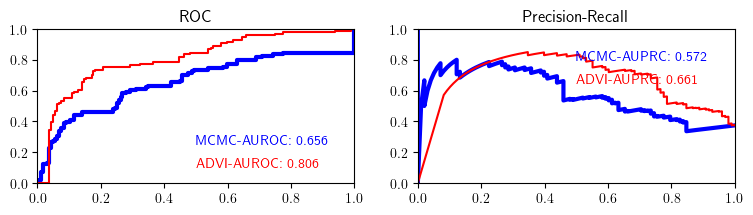

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(fpr, tpr, linewidth=3, color="blue")
ax[0].text(0.5, 0.25, f"MCMC-AUROC: {metrics.auc(fpr, tpr):.3f}", color="blue")

ax[0].plot(fpr_advi, tpr_advi, color="red")
ax[0].text(0.5, 0.1, f"ADVI-AUROC: {metrics.auc(fpr_advi, tpr_advi):.3f}", color="red")

ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(recall, precision, linewidth=3, color="blue")
ax[1].plot(recall_advi, precision_advi, color="red")
ax[1].text(0.5, 0.8, f"MCMC-AUPRC: {metrics.auc(recall, precision):.3f}", color="blue")
ax[1].text(0.5, 0.65, f"ADVI-AUPRC: {metrics.auc(recall_advi, precision_advi):.3f}", color="red")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

# _ = plt.savefig("roccurve_relu.pdf", bbox_inches='tight')

In [41]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [42]:
base = 4
h_vals = [base**-r for r in range(-2, 8)]

loo_output = []
success = []

for _ in tqdm(range(10)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(
            range(params["b_0"].shape[0]), size=n_samples, replace=False
        )
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}

        params_ = {k: v.numpy()[sample_ndx] for k, v in params.items()}

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(nn_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I",  "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"],
                    }
                ]
                reduced_ndx[n_samples][h][T] = [
                    loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]
                ]
                # print(reduced_ndx[n_samples][h])

    df = pd.DataFrame(records)
    df["rho_rank"] = np.emath.logn(base, df["h"])
    __df__ = df.explode(["khat", "ndx"])[["ndx", "khat", "T"]]

    counts = {}
    counts["n"] = len(__df__[__df__["T"] != "I0"].ndx.unique())
    for T in transforms:
        ___df__ = __df__.loc[(__df__["T"] == T) & (__df__["khat"] < 0.7)]
        counts[T] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "KL") | (__df__["T"] == "Var")) & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") | (__df__["T"] == "LL"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") |  (__df__["T"] == "KL") | (__df__["T"] == "Var"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var", "MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    success += [counts]

100%|██████████| 10/10 [02:21<00:00, 14.11s/it]


In [43]:
success = pd.DataFrame(success)
success_ = success.copy()
success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)

/tmp/ipykernel_757445/438181115.py:3: RuntimeWarning: '<' not supported between instances of 'int' and 'tuple', sort order is undefined for incomparable objects.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_757445/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: KL, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_757445/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Var, dtype: float64' has dtype incompatible with int64, please explicitly cast to a com

In [44]:
success.agg(['mean','std'])

,n,KL,Var,LL,MM1,MM2,"(KL, Var)","(MM1, MM2)","(KL, Var, MM1, MM2)"
mean,7.000000,0.0,0.600000,0.0,2.90000,4.10000,0.600000,4.300000,4.300000
std,2.108185,0.0,0.516398,0.0,1.72884,2.13177,0.516398,2.002776,2.002776


In [45]:
(-success.iloc[:, 1:].sub(success.iloc[:, 0], axis=0)).agg(['mean','std'])

,KL,Var,LL,MM1,MM2,"(KL, Var)","(MM1, MM2)","(KL, Var, MM1, MM2)"
mean,7.000000,6.400000,7.000000,4.100000,2.900000,6.400000,2.700000,2.700000
std,2.108185,2.319004,2.108185,1.449138,0.875595,2.319004,0.948683,0.948683


In [46]:
_df = df.explode(['khat','ndx'])[['rho_rank', 'T', 'ndx', 'khat']]
_df['rho_rank'] *= -1

In [47]:
base_khat = _df[_df['T']=="I"][['ndx', 'khat']].drop_duplicates().to_dict(orient='records')
base_khat = {r['ndx']: r['khat'] for r in base_khat}


In [48]:
_df = _df[(_df["T"]!="I") & (_df["T"]!="I0")]
_df[r'$\log(\hat{k}/\hat{k}_0)$'] = _df.apply(lambda x: x.khat/base_khat[x.ndx], axis=1)
_df[r'$-log_4(\rho)$'] = _df['rho_rank']

In [49]:
_df = _df[_df[r'$\log(\hat{k}/\hat{k}_0)$']<4]

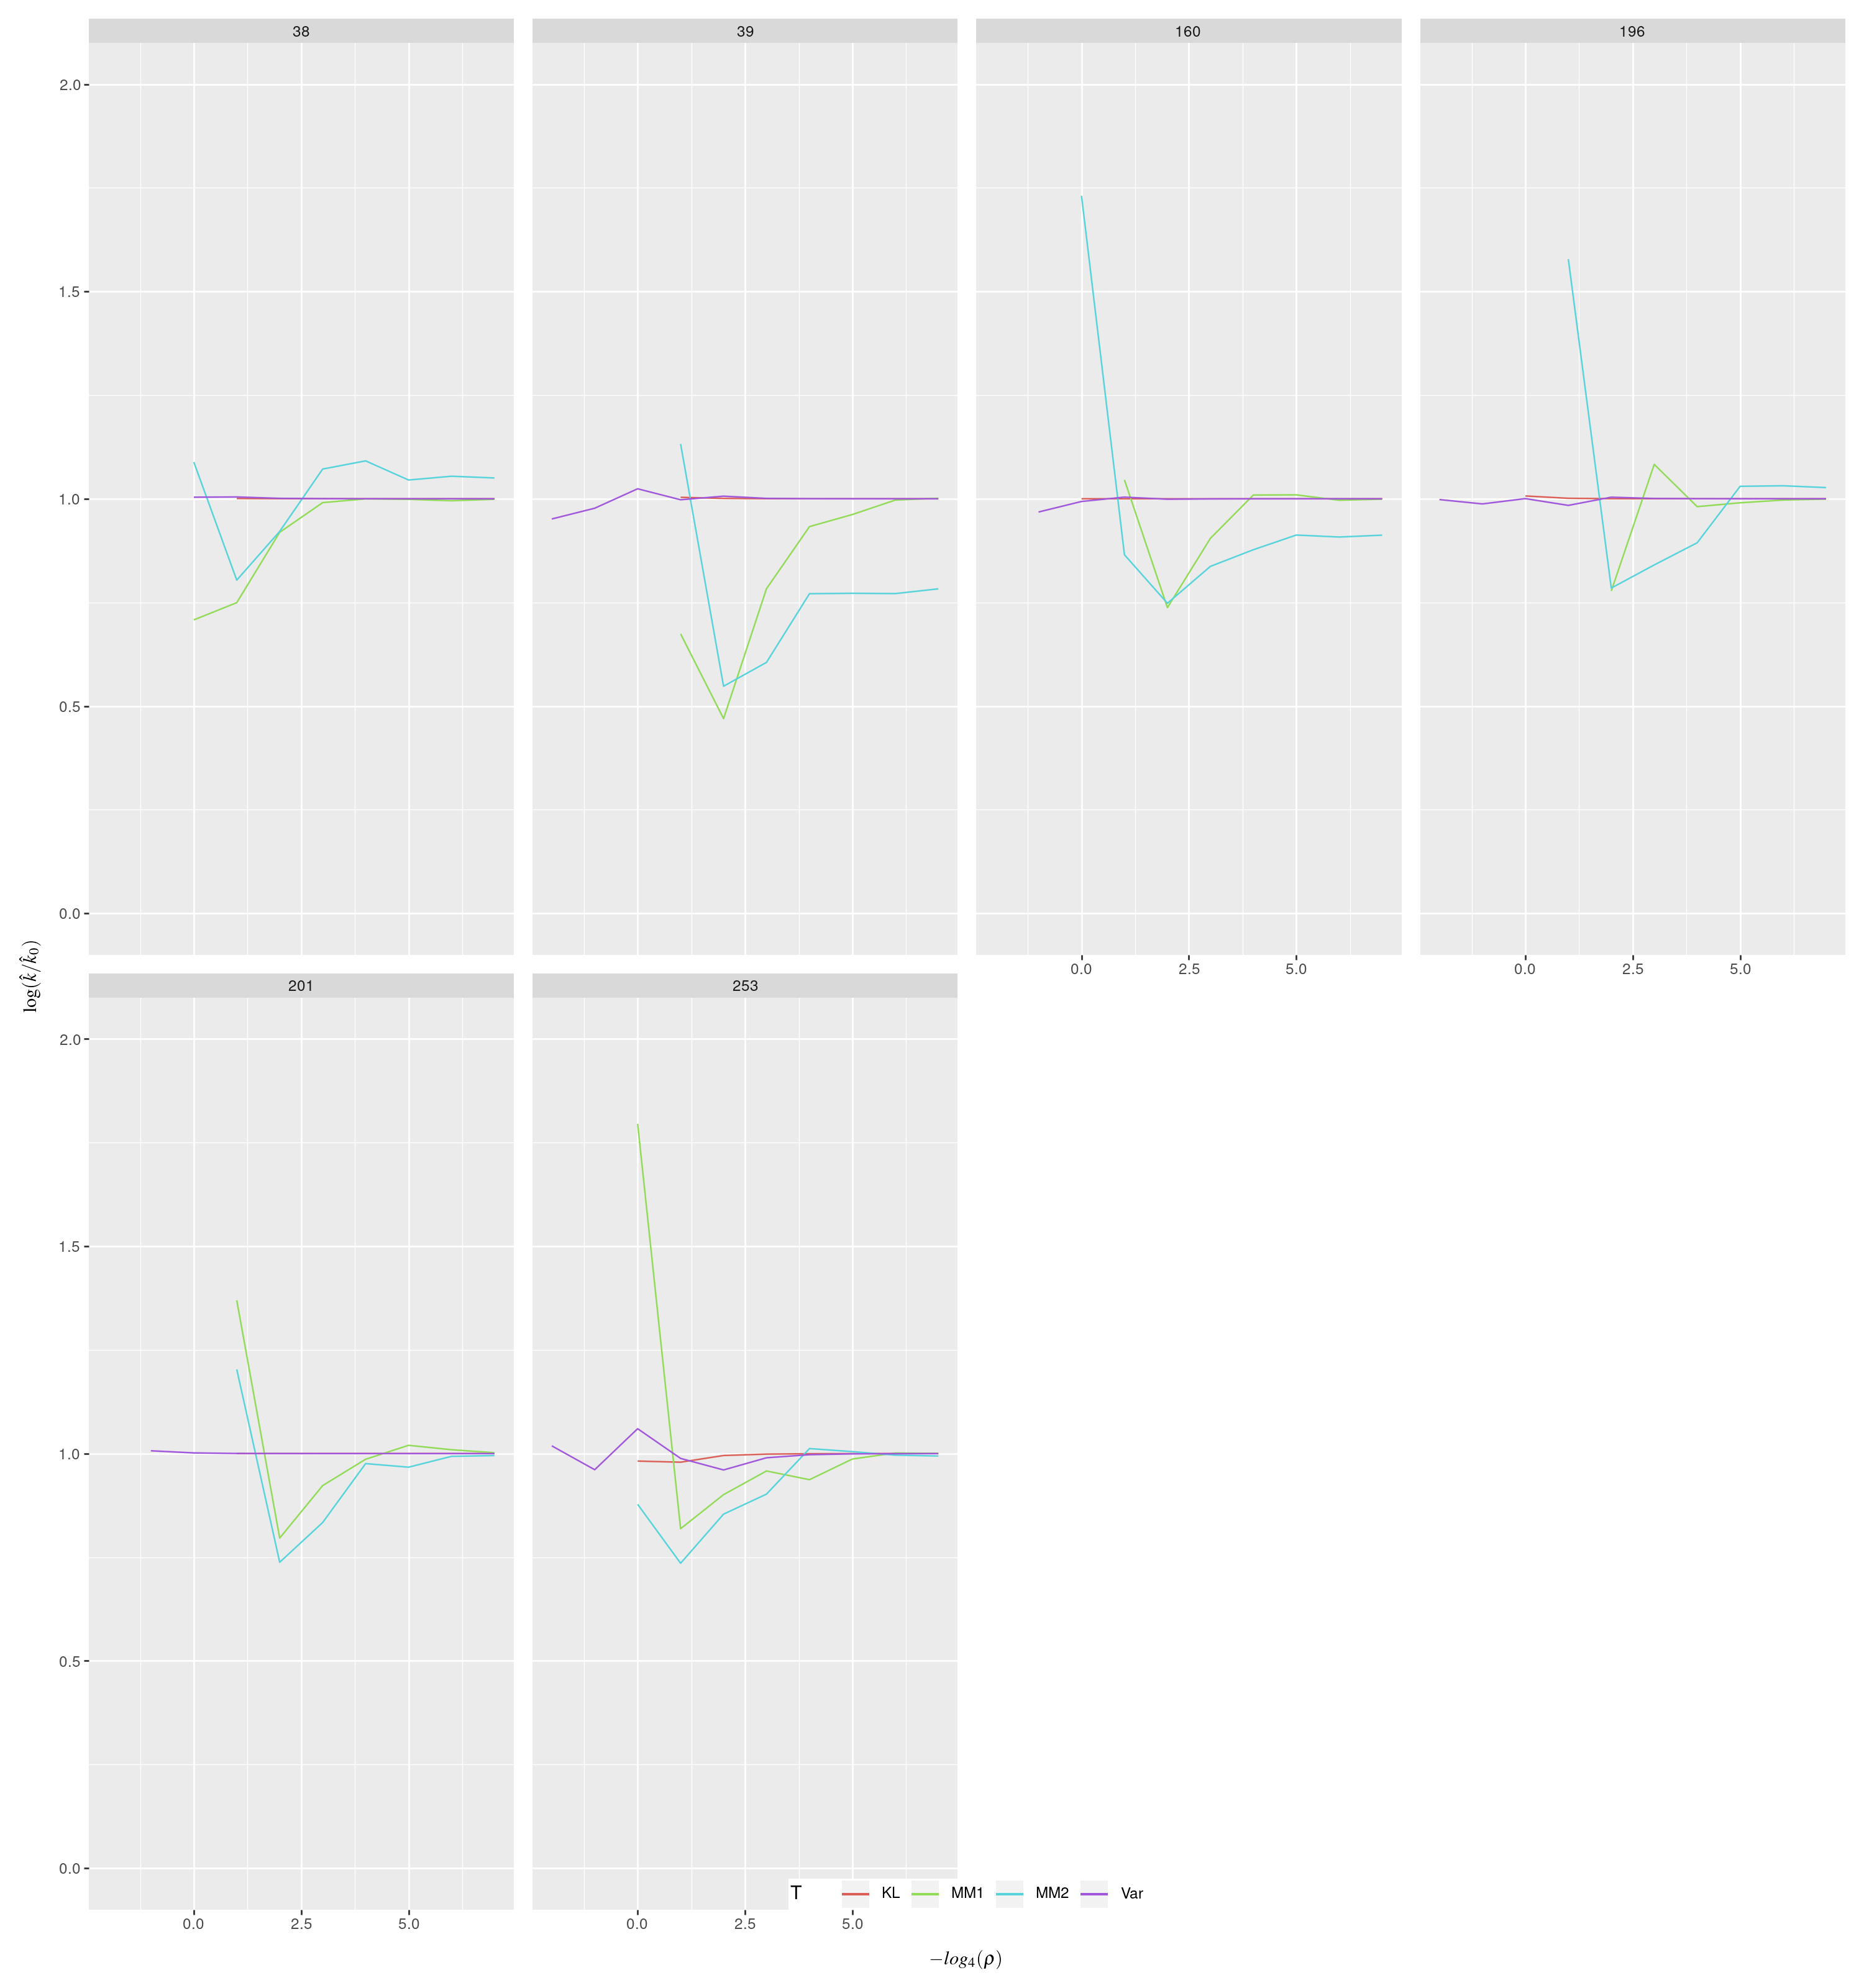

/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 15 x 16 in image.
/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: rho_rank_relu.pdf


In [50]:
from plotnine import ggplot, geom_line, geom_point, aes, stat_smooth, facet_wrap, theme, ylim
from plotnine.data import mtcars


plot = (
    ggplot(_df, aes(r'$-log_4(\rho)$', r'$\log(\hat{k}/\hat{k}_0)$', color="T"))
    + geom_line()
    + facet_wrap("ndx", ncol=4)
    + theme(figure_size=(15, 16), legend_position=(.5, .0), legend_direction='horizontal') + ylim((0, 2))
    
)
plot.show()
plot.save("rho_rank_relu.pdf")